In [25]:
import pandas as pd 
import matplotlib.pyplot as plt
from mplsoccer import Pitch, add_image, FontManager
import requests
import json
from bs4 import BeautifulSoup
from PIL import Image 
from urllib.request import urlopen
from urllib.error import HTTPError
import ScraperFC as sfc

sofascore = sfc.Sofascore()

URL_MATCH = "https://www.sofascore.com/huachipato-cobreloa/jnbsonb#11986410"


### Generar el grafico de ejemplo

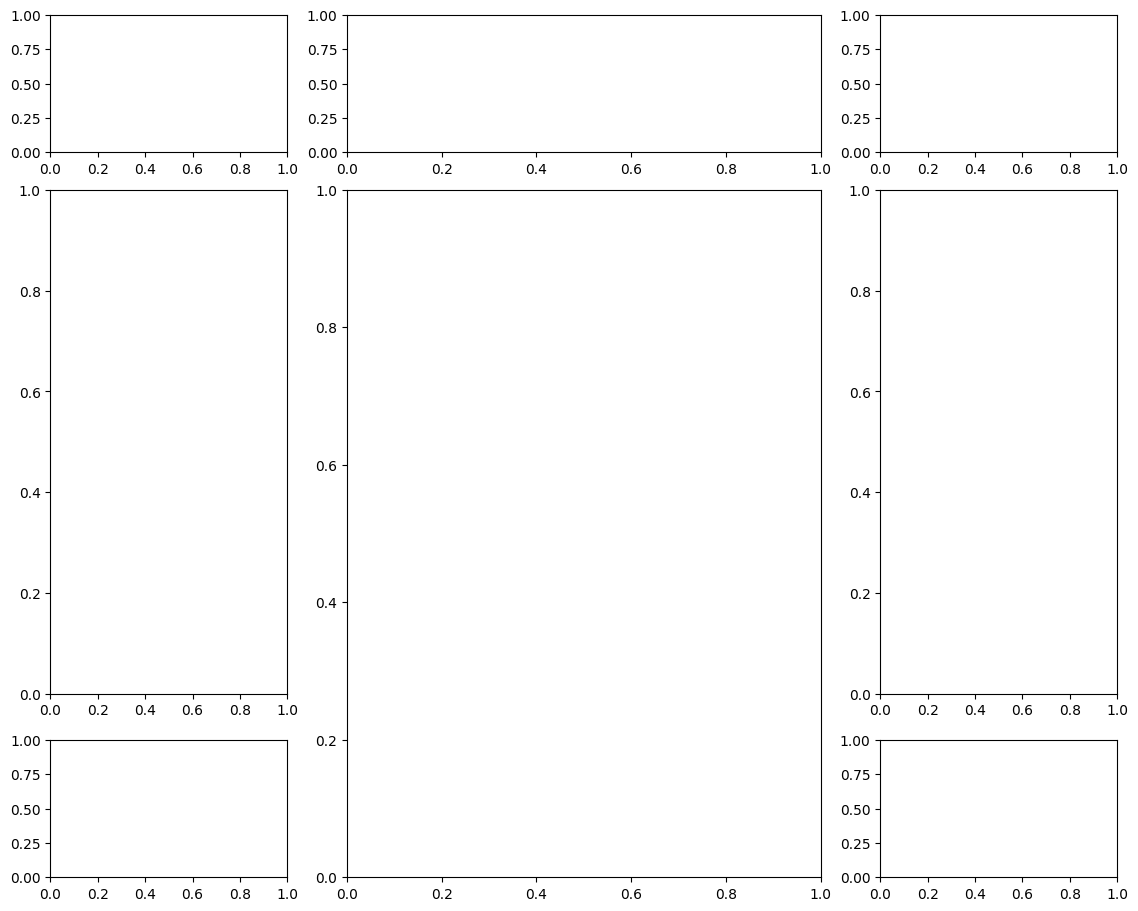

In [26]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# escudo local
ax1 = fig.add_subplot(gs[0,0:1])

# escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])

ax3 = fig.add_subplot(gs[0,1:3])

# equipo local
ax6 = fig.add_subplot(gs[1:4,:1])

ax10 = fig.add_subplot(gs[4:,:1])

ax7 = fig.add_subplot(gs[1:,1:3])

# equipo visitante
ax8 = fig.add_subplot(gs[1:4,3:4])

ax9 = fig.add_subplot(gs[4:,3:4])



### Agregar la fuente

In [10]:
fuente1 = FontManager("https://github.com/google/fonts/blob/main/ofl/abeezee/ABeeZee-Regular.ttf?raw=true")

In [116]:
partido_sofascore = sofascore.get_match_data(URL_MATCH)
nombre_local, nombre_visit = sofascore.get_team_names(URL_MATCH)
estadisticas_partido = sofascore.get_general_match_stats(URL_MATCH)

df_local, df_visit = sofascore.get_players_match_stats(URL_MATCH)

df_local.columns


Index(['name', 'slug', 'shortName', 'position', 'jerseyNumber', 'userCount',
       'id', 'country', 'marketValueCurrency', 'dateOfBirthTimestamp',
       'firstName', 'lastName', 'shirtNumber', 'jerseyNumber', 'position',
       'substitute', 'totalPass', 'accuratePass', 'totalLongBalls',
       'accurateLongBalls', 'savedShotsFromInsideTheBox', 'saves',
       'totalKeeperSweeper', 'accurateKeeperSweeper', 'minutesPlayed',
       'touches', 'rating', 'possessionLostCtrl', 'ratingVersions',
       'totalCross', 'accurateCross', 'aerialLost', 'aerialWon', 'duelLost',
       'duelWon', 'challengeLost', 'dispossessed', 'totalContest',
       'shotOffTarget', 'totalClearance', 'interceptionWon', 'totalTackle',
       'keyPass', 'outfielderBlock', 'fouls', 'wonContest', 'bigChanceCreated',
       'wasFouled', 'onTargetScoringAttempt', 'goals', 'bigChanceMissed',
       'blockedScoringAttempt', 'totalOffside', 'captain', 'team'],
      dtype='object')

### Obtener los jugadores destacados en esas metricas

In [50]:
lista_mayores = ['duelWon', 'touches', 'keyPass', 'accuratePass'] # hay ligas que no tienen xG ni xA
nombre_mayores_local = []
valor_mayores_local = []
nombre_mayores_visit = []
valor_mayores_visit = []

# equipo local
for i in range(len(lista_mayores)):
    nombre = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_local.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_local.append(nombre)
    valor_mayores_local.append(valor)
    
# equipo visitante
for i in range(len(lista_mayores)):
    nombre = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][0]
    valor = df_visit.sort_values(by=lista_mayores[i], ascending=False)[['name', lista_mayores[i]]].values[0][1]
    nombre_mayores_visit.append(nombre)
    valor_mayores_visit.append(valor)
    
nombre_mayores_local, valor_mayores_local

(['Marco Borgnino', 'Marco Campagnaro', 'Marco Campagnaro', 'Bastian Tapia'],
 [9.0, 62.0, 2.0, 39.0])

### Obtener imagen del jugador destacado de cada equipo

In [65]:
jugador_destacado_local = df_local[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
jugador_destacado_visit = df_visit[['name', 'rating']].sort_values(by='rating', ascending=False).iloc[0]['name']
id_jug_local = df_local[df_local['name'] == jugador_destacado_local].id.values[0]
id_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit].id.values[0]

try:
  imagen_jug_local = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_local}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_local = ''

try:
  imagen_jug_visit = Image.open(urlopen(f'https://api.sofascore.app/api/v1/player/{id_jug_visit}/image'))
except HTTPError as e:
  print(f'An exception occurred {e}')
  imagen_jug_visit = ''



### Sacar inforamcion de cada jugador

In [67]:
df_jug_local = df_local[df_local['name'] == jugador_destacado_local]
df_jug_visit = df_visit[df_visit['name'] == jugador_destacado_visit]

df_jug_local.columns

Index(['name', 'slug', 'shortName', 'position', 'jerseyNumber', 'userCount',
       'id', 'country', 'marketValueCurrency', 'dateOfBirthTimestamp',
       'firstName', 'lastName', 'shirtNumber', 'jerseyNumber', 'position',
       'substitute', 'totalPass', 'accuratePass', 'totalLongBalls',
       'accurateLongBalls', 'savedShotsFromInsideTheBox', 'saves',
       'totalKeeperSweeper', 'accurateKeeperSweeper', 'minutesPlayed',
       'touches', 'rating', 'possessionLostCtrl', 'ratingVersions',
       'totalCross', 'accurateCross', 'aerialLost', 'aerialWon', 'duelLost',
       'duelWon', 'challengeLost', 'dispossessed', 'totalContest',
       'shotOffTarget', 'totalClearance', 'interceptionWon', 'totalTackle',
       'keyPass', 'outfielderBlock', 'fouls', 'wonContest', 'bigChanceCreated',
       'wasFouled', 'onTargetScoringAttempt', 'goals', 'bigChanceMissed',
       'blockedScoringAttempt', 'totalOffside', 'captain', 'team'],
      dtype='object')

### obtener informacion de los equipos

In [98]:
# id equipos
idlocal = partido_sofascore['homeTeam']['id']
idvisit = partido_sofascore['awayTeam']['id']

# escudos de los equipos
imagen1 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idlocal}/image'))
imagen2 = Image.open(urlopen(f'https://api.sofascore.app/api/v1/team/{idvisit}/image'))

# goles de los equipos
goleslocal = partido_sofascore['homeScore']['normaltime']
golesvisit = partido_sofascore['awayScore']['normaltime']


### Sacar info de la jornada

In [74]:
torneo = partido_sofascore['season']['name']
fecha = partido_sofascore['roundInfo']['round']

f'{nombre_local} - {nombre_visit}'

'Cobreloa - Huachipato'

### Quitar las lineas de los plots

In [99]:
def sacar_spines(ax):
    ax.spines[['top', 'right', 'bottom', 'left']]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

### Obtener estadísticas de cada equipo por separado

In [95]:
listas_estadisticas_partido = estadisticas_partido['name'].to_list()
lista_valores_partido_local = []
lista_valores_partido_visit = []

# equipo local
for i in range(len(listas_estadisticas_partido)):
    valor = estadisticas_partido[estadisticas_partido['name'] == listas_estadisticas_partido[i]]['home'].values[0]
    lista_valores_partido_local.append(valor)
    
# equipo visitante
for i in range(len(listas_estadisticas_partido)):
    valor = estadisticas_partido[estadisticas_partido['name'] == listas_estadisticas_partido[i]]['away'].values[0]
    lista_valores_partido_visit.append(valor)
    



### Agregar la informacion al plot

Text(0.525, 0.8, 'Huachipato')

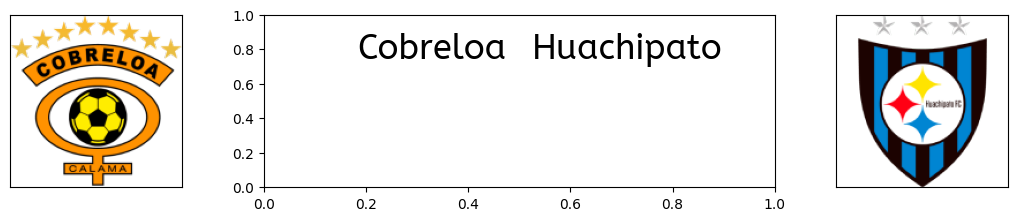

In [117]:
fig = plt.figure(figsize=(16,9),constrained_layout=True)
gs = fig.add_gridspec(nrows=5,ncols=6)
fig.set_facecolor('white')

# Escudo local
ax1 = fig.add_subplot(gs[0,0:1])
ax1.imshow(imagen1)
sacar_spines(ax1)

# Escudo visitante
ax2 = fig.add_subplot(gs[0,3:4])
ax2.imshow(imagen2)
sacar_spines(ax2)

# infor del partido
ax3 = fig.add_subplot(gs[0, 1:3])
ax3.text(.475, .8, f'{nombre_local}', ha='right', va='center', fontproperties=fuente1.prop, size=25)
ax3.text(.525, .8, f'{nombre_visit}', ha='left', va='center', fontproperties=fuente1.prop, size=25)